# Pre-Processing the MicroCTD Data
# Part 1: From Matlab to the treatable data!

### You'll find the files to run this notebook at https://github.com/GutoSchettini/MicroCTD_Data_Processing

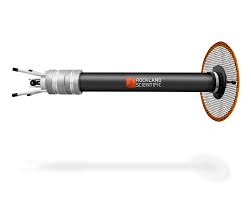  

Guto Schettini, 30.May.2025


# Step 1: Convert the '.P' file in '.mat' files

# In Matlab  

1) Go to your working directory (here "D:\GUTO\1_Trabs\MicroCTD_Rockland")

2) Be sure you have the Rockland's 'odas' toolbox, and copy the 'quick_look_Guto.m' to the same directory 

2) Add 'Odas' in the path, with 'select folder and subfolders' (just in case...)

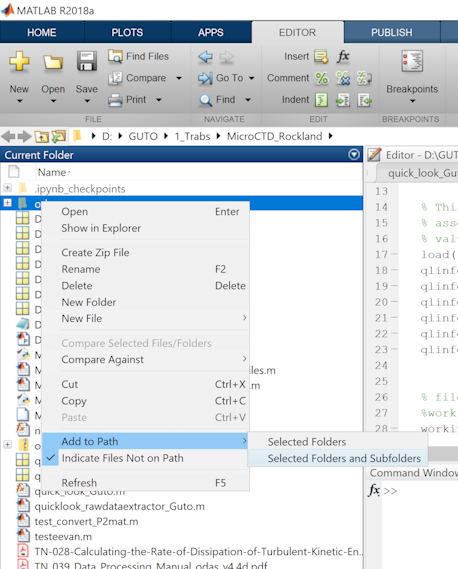

3) Copy the script 'MicroCTD_Guto_RawDataExtractor.m' to your working directory

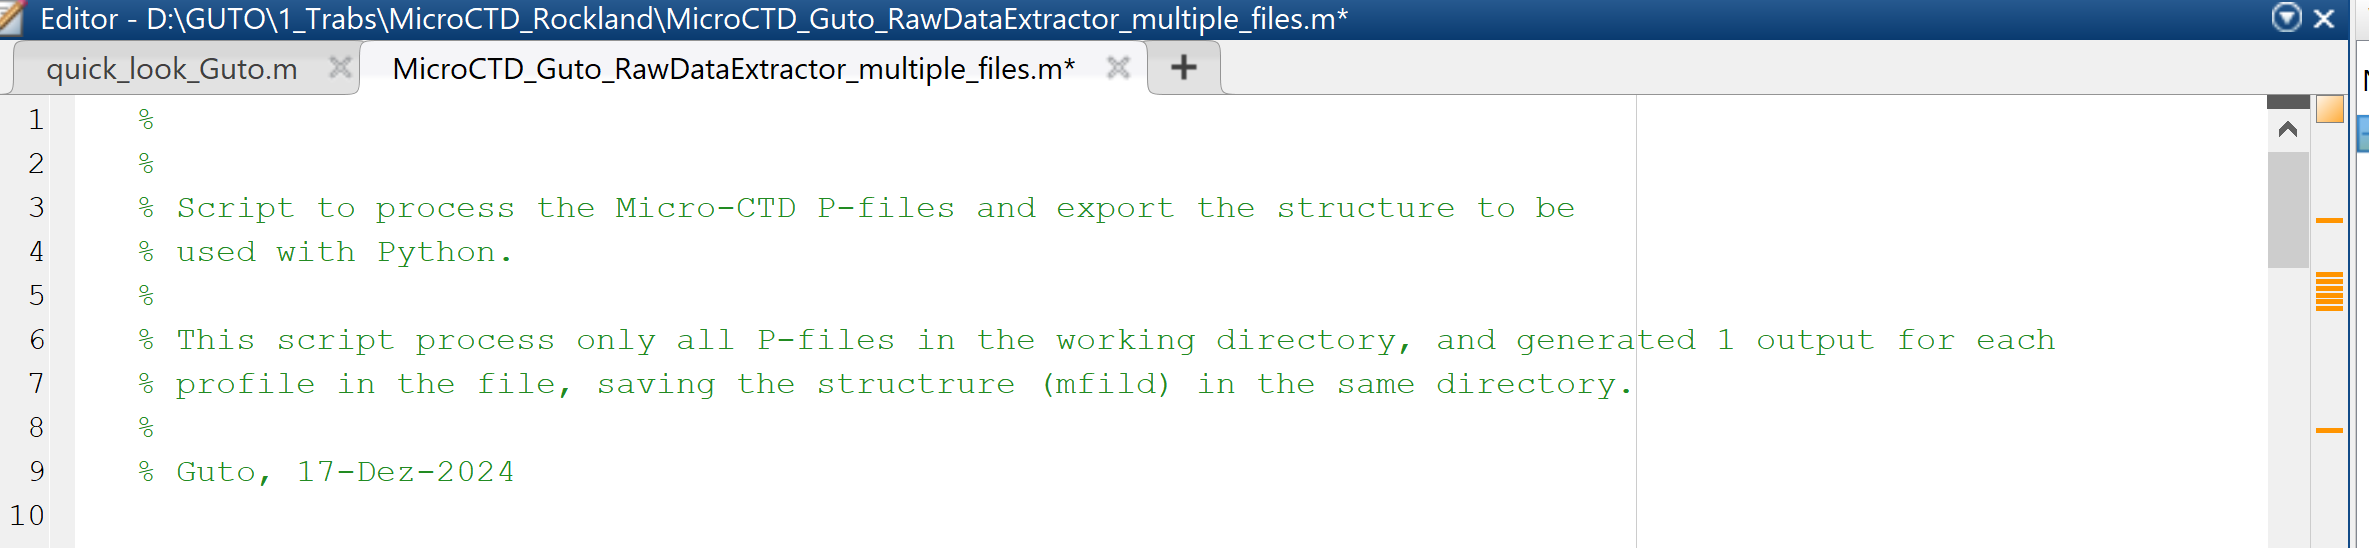

4) You may want to change some of 'qlinfo.mat' settings... the present setup gives a nearly 0.5 m vertical resolution for the dissipation rate
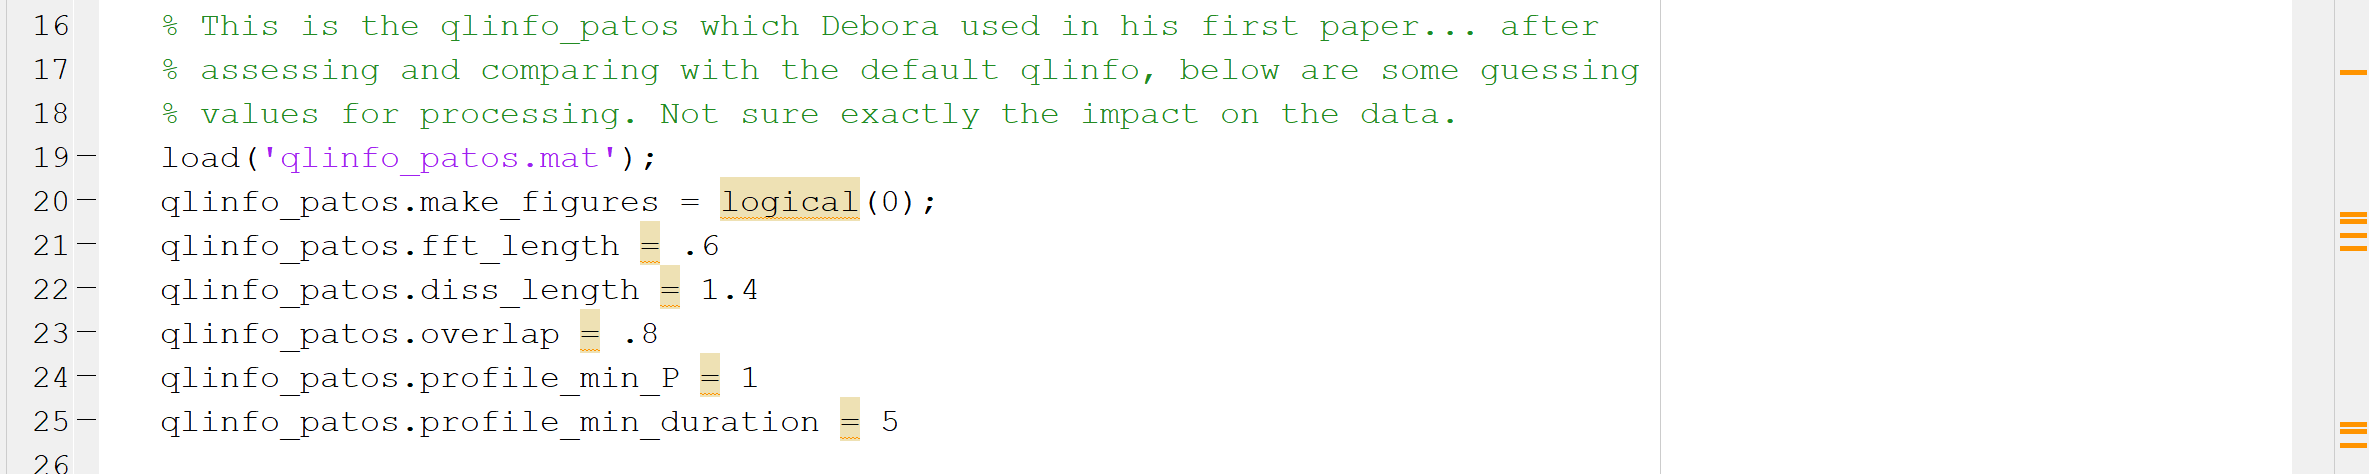

5) Select the directory where your P files are

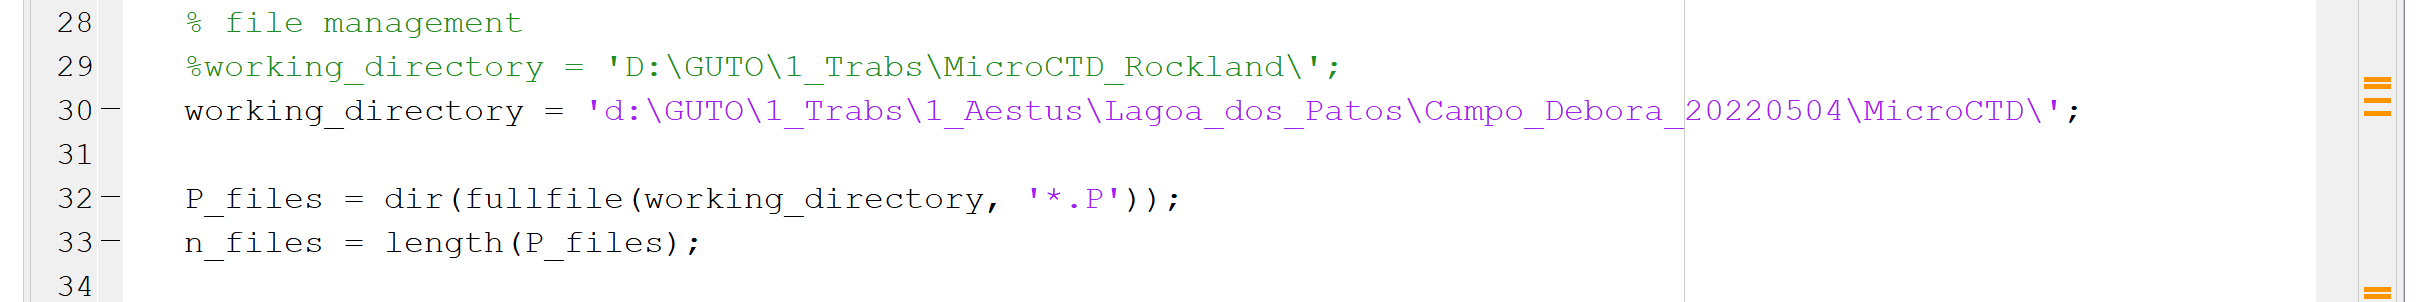

6) When 'run', the processing will appear in the 'Command Window'. The modified 'quick_look_Guto.m' will generate a '.mat' file for each vertical profile in the '.P' file, and the file names fill star with the original name, the number of the profile, and date and hour when the profile started. The files will be save in the same working directory of the '.P' files, or you can change the address in the code. 

Example: 'DAT_015_profile_003_20220504_072318.m'

# In Python/Jupyter 
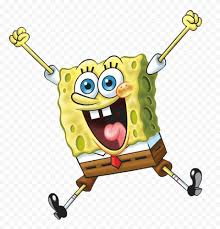

In [1]:
import os
import scipy.io as scio
from dateutil.parser import parse
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pickle

### Checking if you are in the right place and have the right files!

In [2]:
path = r'D:\GUTO\1_Trabs\MicroCTD_Rockland\\'
dirfiles = os.listdir(path)

# create a list of processed profiles
profile_files = []
for f in dirfiles:
    if ('profile' in f) and (f.endswith('.mat') == True):
        profile_files.append(f)
        print(f)

DAT_015_profile_001_20220504_072318.mat
DAT_015_profile_002_20220504_072416.mat
DAT_015_profile_003_20220504_072519.mat
DAT_015_profile_004_20220504_072617.mat
DAT_015_profile_005_20220504_072852.mat
DAT_015_profile_006_20220504_073031.mat


### Load the .mat files

In [3]:
profiles_mat = []
for f in profile_files:
    mat = scio.loadmat(path + f)
    profiles_mat.append(mat)

### Selecting the data of interest and build the output arrays
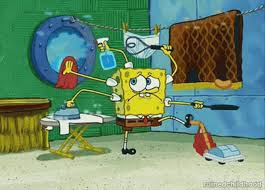

In [4]:
profile_data = []

for mat in profiles_mat:
    # crack the structures
    dados = mat['junta']
    time = dados['file_datetime'][0][0][0]
    dissipation = dados['dissipation'][0][0]
    data_slow = dados['Data_slow'][0][0]
    data_fast = dados['Data_fast'][0][0]
    hdr_slow = dados['slow_list'][0][0]
    hdr_fast = dados['fast_list'][0][0]

    # split the dissipation Array and test according Stips, 2005 - book Marine Turbulence!
    dissip_1 = dissipation[0,:]
    dissip_2 = dissipation[1,:]
    for i in range(len(dissip_1)):
        if dissip_1[i] > 2*dissip_2[i]:
            dissip_1[i] = dissip_2[i]
        if dissip_2[i] > 2*dissip_1[i]:
            dissip_2[i] = dissip_1[i]
    

    # list of the variables, if you want check later
    hdr_slow = [x[0] for x in hdr_slow[0][:]]
    hdr_fast = [x[0] for x in hdr_fast[0][:]]

    time_dt = parse(time) # to convert to datetime
    time_seconds_from_start = data_slow[28,0]
    # time of the profile in local time
    time_profile = time_dt + datetime.timedelta(seconds = time_seconds_from_start) + datetime.timedelta(hours=-3)
    time_profile_n = mdates.date2num(time_profile)
    
    # slicing...
    pressure = data_slow[11,:]
    salinity = data_slow[12,:]
    temperature = data_slow[17,:]
    density = data_slow[26,:] + 1000
    fall_velocity = data_slow[19,:]
    inclination = data_slow[4,:]

    # the data from the ODAS are not regularly spaced in the vertical (pressure). See the cell below!
    press_i = np.arange(1.6, np.max(pressure), 0.5)
    sal_i = np.interp(press_i, pressure, salinity)
    temp_i = np.interp(press_i, pressure, temperature)
    dens_i = np.interp(press_i, pressure, density)
    dissip_1i = np.interp(press_i, pressure, dissip_1)
    dissip_2i = np.interp(press_i, pressure, dissip_2)
    fall_i = np.interp(press_i, pressure, fall_velocity)
    inclin_i = np.interp(press_i, pressure, inclination)

    time_profile_nn = np.linspace(time_profile_n, time_profile_n, len(press_i))
    
    # building
    j_profile_data = np.vstack((time_profile_nn, 
                                press_i, 
                                sal_i, 
                                temp_i, 
                                dens_i, 
                                dissip_1i,
                                dissip_2i,
                                fall_i,
                                inclin_i)).T

    profile_data.append(j_profile_data)
    print(time_profile)

2022-05-04 04:23:18.140369
2022-05-04 04:24:16.792867
2022-05-04 04:25:19.507606
2022-05-04 04:26:17.285160
2022-05-04 04:28:52.290870
2022-05-04 04:30:31.925122


### The need of the vertical interpolation!  
The data is not regularly spaced in the vertical... and it need be for averaging later!

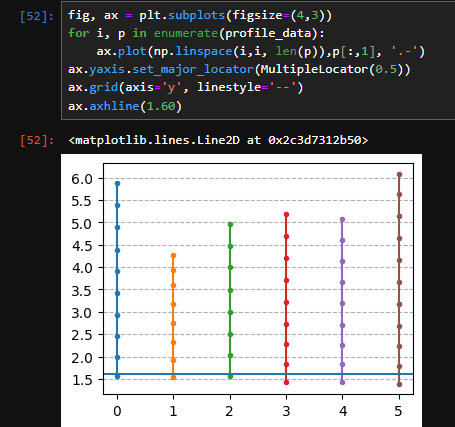

In [5]:
for i, h in enumerate(hdr_slow):
    print(i, h)

0 C_CTD
1 C_CTD_match
2 Incl_T
3 Incl_X
4 Incl_Y
5 Indep_var_slow
6 JAC_C
7 JAC_T
8 P
9 PV
10 P_dP
11 P_slow
12 S_CTD
13 T1
14 T1_slow
15 T2
16 T2_slow
17 T_CTD
18 V_Bat
19 W
20 W_slow
21 ch255
22 dP_dt
23 dP_dt_LP
24 m
25 potential_T
26 potential_density
27 speed_slow
28 t_slow
29 t_slow_YD


In [6]:
for i, h in enumerate(hdr_fast):
    print(i, h)

0 Ax
1 Ay
2 Indep_var_fast
3 P_fast
4 T1_dT1
5 T1_fast
6 T2_dT2
7 T2_fast
8 W_fast
9 gradT1
10 gradT2
11 n
12 sh1
13 sh2
14 speed_fast
15 t_fast
16 t_fast_YD
17 temperature_fast


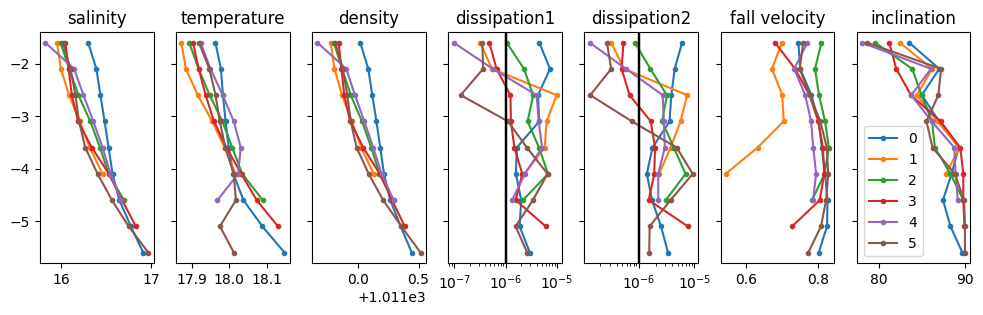

In [7]:
fig, axs = plt.subplots(1,7, figsize=(12,3))
titles = ['salinity', 'temperature', 'density', 'dissipation1', 'dissipation2', 'fall velocity', 'inclination']
for i,d in enumerate(profile_data):
    for c in range(2, 9):
        axs[c-2].plot(d[:,c], -d[:,1], '.-', label=str(i))

    if c == 8:
        axs[c-2].legend() # to help to identify the profiles

    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        if i > 0:
            ax.set_yticklabels('')
        if i in [3, 4]:
            ax.set_xscale('log')
            ax.axvline(1e-6, color='k')


So, the second profile (i = 1) seems to be a bad one... we can pop it out, and pickle the list to continue the processing in another notebook.

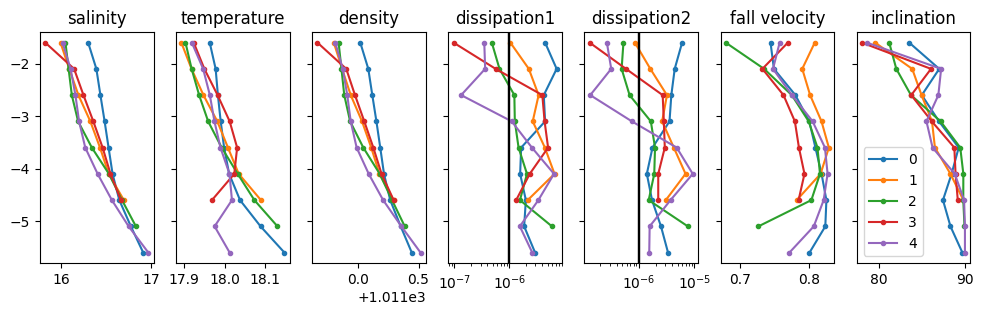

In [8]:
pd2 = profile_data.copy()
pd2.pop(1)

fig, axs = plt.subplots(1,7, figsize=(12,3))
titles = ['salinity', 'temperature', 'density', 'dissipation1', 'dissipation2', 'fall velocity', 'inclination']
for i,d in enumerate(pd2):
    for c in range(2, 9):
        axs[c-2].plot(d[:,c], -d[:,1], '.-', label=str(i))

    if c == 8:
        axs[c-2].legend() # to help to identify the profiles

    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        if i > 0:
            ax.set_yticklabels('')
        if i in [3, 4]:
            ax.set_xscale('log')
            ax.axvline(1e-6, color='k')

It is a good pratice to add a header in the pikled file... 

In [9]:
hdr = ''' 
MicroCTD profiles pre-processed data ...
By me, in some rainy day...
'''

columns = ['time_profile','pressure','salinity','temperature','density','dissipation1','dissipation2','fall velocity','inclination']
           
j = [hdr, columns, pd2]

with open('MicroCTD_preprocessed_data_demo.pkl', 'wb') as io:
    pickle.dump(j, io)
